In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import functional as F
from torchsummary import summary
import torch_optimizer as optim

from load_data import *
from Utility import *

np.set_printoptions(precision=3)

# Loading preprocessed data (that is already filtered with linear fir)

<IPython.core.display.Javascript object>


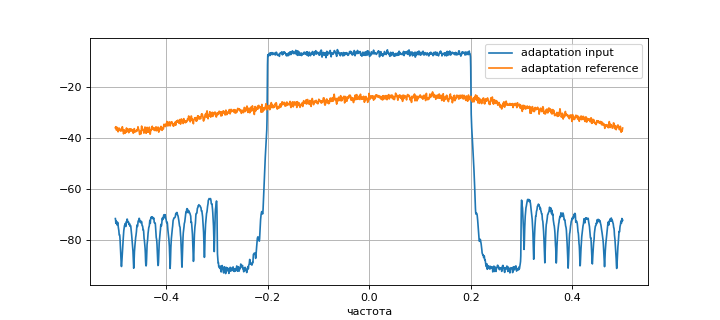

In [2]:
%matplotlib notebook

# adaptation input and reference
a_in_cmplx, a_ref_cmplx = load_for_non_linear_adaptation("data/test1_25p0.mat")

# normalization of input and reference dynamic range to [-1, 1]
# it helps with numerical acuuracy, especially when we are wroking with raw polynomials
# it is also necessary if we are going to use chebyshev or other polynomials 
a_max = np.max(np.hstack([np.abs(a_in_cmplx.real), np.abs(a_in_cmplx.imag), 
                          np.abs(a_ref_cmplx.real), np.abs(a_ref_cmplx.imag)]))
a_in_cmplx/=a_max
a_ref_cmplx/=a_max

# separate i/q channels cause torch is not really good at working with complex (experimental)
#cuda0 = torch.device('cuda:0')
device = torch.device('cuda:0')
a_in = torch.tensor(np.vstack([a_in_cmplx.real, a_in_cmplx.imag]), dtype=torch.float32, device=device)
a_ref = torch.tensor(np.vstack([a_ref_cmplx.real, a_ref_cmplx.imag]), dtype=torch.float32, device=device)

# plot input data
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
plot_psd([a_in_cmplx, a_ref_cmplx], ax=ax)

plt.legend(['adaptation input', 'adaptation reference'])

In [3]:
# some feature enginering
a_in = torch.tensor(np.vstack([a_in_cmplx.real, a_in_cmplx.imag, np.abs(a_in_cmplx)]), 
                    dtype=torch.float32, device=device)


# let's consider some simple cnn architectures

In [11]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=5, kernel_size=3, padding='same', padding_mode='zeros')
        self.activation1 = nn.Tanh()
        
        self.conv2 = nn.Conv1d(in_channels=5, out_channels=5, kernel_size=5, padding='same', padding_mode='zeros')
        self.activation2 = nn.LeakyReLU()
        
        self.conv3 = nn.Conv1d(in_channels=5, out_channels=2, kernel_size=3, padding='same', padding_mode='zeros')

    def forward(self, x):
        x = self.activation1(self.conv1(x))
        x_tmp = x
        x = self.activation2(self.conv2(x))
        x = x+x_tmp
        x = self.conv3(x)
        return x

In [13]:
model = Simple_CNN().to(device)
summary(model.cuda(), (3, 10000))
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 5, 10000]              50
              Tanh-2             [-1, 5, 10000]               0
            Conv1d-3             [-1, 5, 10000]             130
         LeakyReLU-4             [-1, 5, 10000]               0
            Conv1d-5             [-1, 2, 10000]              32
Total params: 212
Trainable params: 212
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 1.68
Params size (MB): 0.00
Estimated Total Size (MB): 1.79
----------------------------------------------------------------


In [15]:
learning_rate = 20e-4
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.QHAdam(
    model.parameters(),
    lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,
)
losses = []

<IPython.core.display.Javascript object>


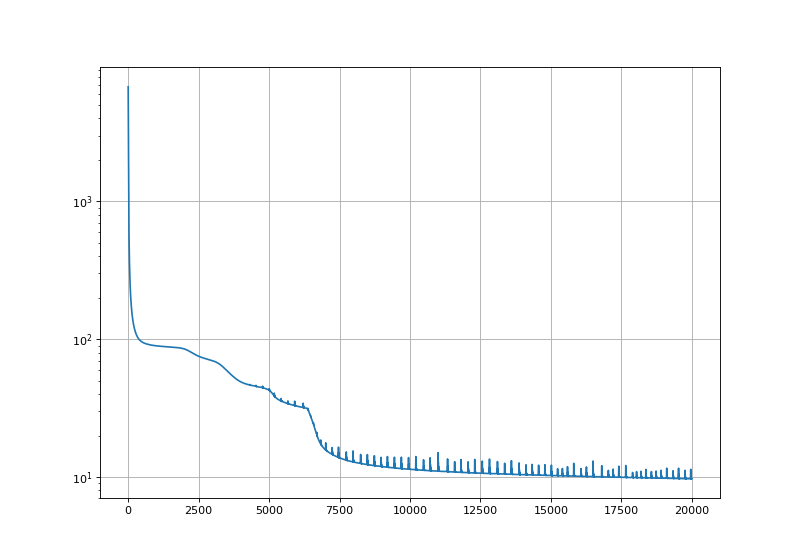

Обучение закончено


In [16]:
%matplotlib notebook

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

final_output = None

for epoch in range(20000):
    optimizer.zero_grad()

    y_pred = model(a_in.view((1,a_in.shape[0], a_in.shape[1])).to(device))
    loss = torch.sum((a_ref.view((-1, )) - y_pred.view((-1,))) ** 2)
    loss.backward()
    optimizer.step()

    losses.append(loss.cpu().detach().numpy())
    final_output = y_pred.cpu().detach().numpy()

ax.clear()
ax.plot(np.arange(len(losses)), losses)
ax.grid(True)
ax.set_yscale('log')
plt.show()

final_output = final_output[0]

print('Обучение закончено')

<IPython.core.display.Javascript object>


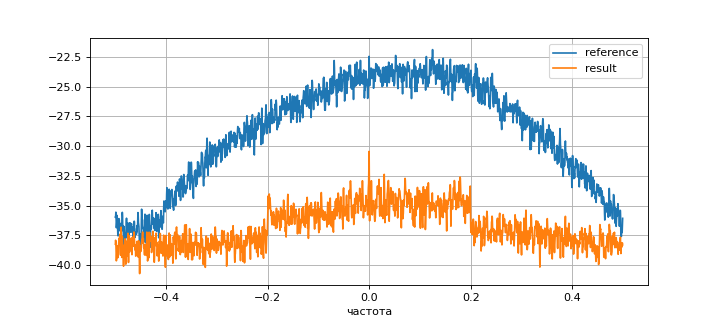

In [17]:
%matplotlib notebook

cnn_out_cmplx = final_output[0] + 1j*final_output[1]

# plot input data
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
plot_psd([a_ref_cmplx, a_ref_cmplx-cnn_out_cmplx], ax=ax)

plt.legend(['reference','result'])

In [27]:
final_output.shape

(2, 43840)